<a href="https://colab.research.google.com/github/98bao/Migros/blob/main/code/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
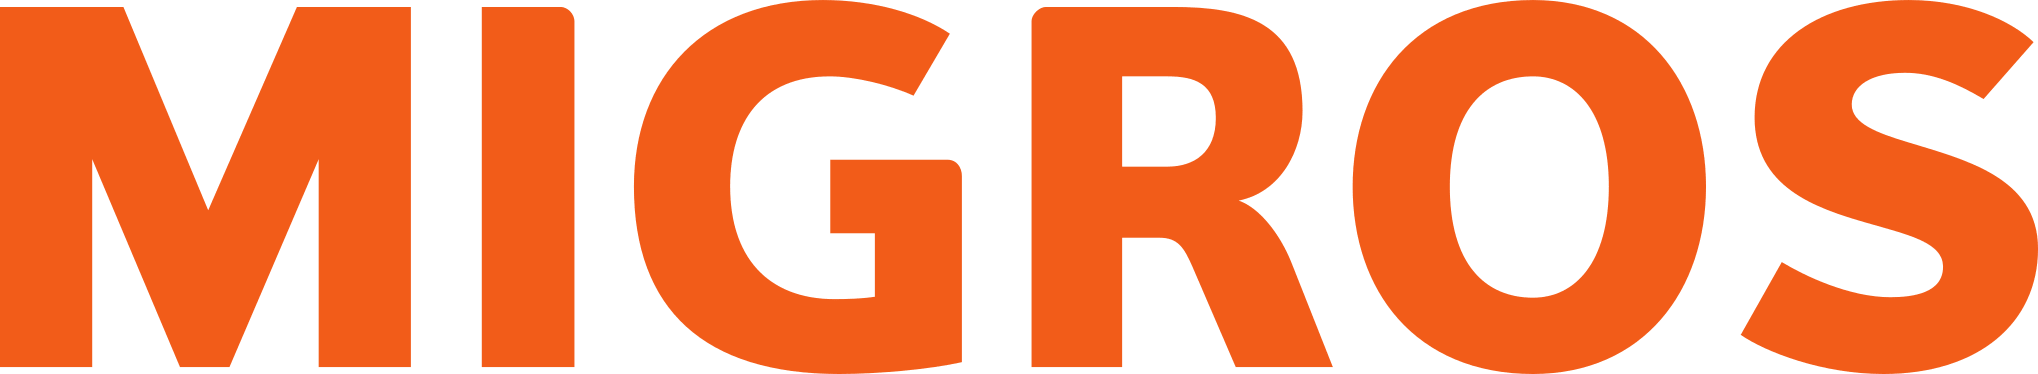
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).
A detailed description of the course of action can be found in the file Report.

---



# Importing useful tools 🧰

In [2]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [3]:
#clear output
%%capture 
# Install and update spaCy
!pip install -U spacy
!python -m spacy download en

In [5]:
#Importing useful extensions
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import spacy

from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from gensim.parsing.preprocessing import remove_stopwords

# Importing the project dataframes in the notebook 📚
In the following cells, we import some raw dataframes that we are going to use for the project

In [7]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)


id    keyword  ...                                               text target
0   3738  destroyed  ...  Black Eye 9: A space battle occurred at Star O...      0
1    853  bioterror  ...  #world FedEx no longer to transport bioterror ...      0
2  10540  windstorm  ...  Reality Training: Train falls off elevated tra...      1
3   5988  hazardous  ...  #Taiwan Grace: expect that large rocks trees m...      1
4   6328    hostage  ...  New ISIS Video: ISIS Threatens to Behead Croat...      1

[5 rows x 5 columns]

In [12]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(5)

id  ...                                               text
0  9972  ...  Crptotech tsunami and banks.\n http://t.co/KHz...
1  9865  ...  I'm that traumatised that I can't even spell p...
2  1937  ...  @foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3  3560  ...  Me watching Law &amp; Order (IB: @sauldale305)...
4  2731  ...                  Papi absolutely crushed that ball

[5 rows x 4 columns]

In [14]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

# Exploratory data analysis 🕵️

In the following cells, we explore the train dataset which we will be using to build a model. the subsection will describe the attributes listed below:

* Dataframe description   
* Base Rate 
* Location Exploration 
* Text exploration 
* Keywords exploration

## Data description 

Short description to have an estimate the dataframe we will be using.

In [17]:
#shape of data 
print("Shape of data:", df_train.shape)
print ("Number of Rows:", df_train.shape[0])
print ("Number of Columns", df_train.shape[1])

Shape of data: (6471, 5)
Number of Rows: 6471
Number of Columns 5


In [18]:
#Name of columns
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [16]:
#Sample of the column 'text' which will be analyzed
print("Train set sample:", df_train['text'].sample().values[0])
print("Test set sample:", df_test['text'].sample().values[0])

Train set sample: Lately I been stressing make me wanna put a fuck nigga on a stretcher!
Test set sample: disinfo: Warfighting Robots Could Reduce Civilian Casualties So Calling for a Ban Now Is ... -... http://t.co/yUinMErQ2s #criticalmedia


In [19]:
#Null values 
df_train.isnull().sum()

id             0
keyword       55
location    2141
text           0
target         0
dtype: int64

## Base rate
An indication of how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [20]:
#Number of tweets in df_train  that support or not a real disaster 
Tweets_support = len(df_train[df_train['target'] == 1])
Tweets_does_not_support = len(df_train[df_train['target'] == 0])
print("Number of tweets that does not support a real disaster : ", Tweets_does_not_support)
print("Number of tweets that support a real disaster:", Tweets_support)

Number of tweets that does not support a real disaster :  3701
Number of tweets that support a real disaster: 2770


In [21]:
#Base rate of the train df
r = df_train['target'].value_counts() /len(df_train) 
print("Base rate =", max(r))

Base rate = 0.5719363313243703


## Location

Exploration about the location in this dataset. There are 2922 different location present in the train set.

In [ ]:
df_train['location']

In [22]:
#Location null values
df_train.location.isnull().sum()

2141

In [23]:
# Number of location
loc_len =len(df_train['location'].unique())
print("Number of locations:", loc_len)

Number of locations: 2922


## Keywords

Following some information about the attribute keyword. There are 222 different keywords available in this dataset.

In [ ]:
df_train['keyword']

In [24]:
#Location null values
df_train.keyword.isnull().sum()

55

In [26]:
#Number of keywords
key_len = len(df_train['keyword'].unique())
print("Number of keywords:", key_len)


Number of keywords: 222


## Text Exploration


In [29]:
#Total number of words in the train set
print("Total Number of Words in train set:", df_train['text'].apply(lambda x: len(x.split(' '))).sum())

#Total number of words in the test set
print("Total Number of Words in test set:", df_test['text'].apply(lambda x: len(x.split(' '))).sum())

Total Number of Words in train set: 96544
Total Number of Words in test set: 17110


In [30]:
#Check duplicates 
print('Entire Duplicated rows:', df_train.duplicated().sum())
print('Duplicated Text:', df_train['text'].duplicated().sum())
print('Duplicated Keywords:', df_train['keyword'].duplicated().sum())
print('Duplicate Locations:', df_train['location'].duplicated().sum())

Entire Duplicated rows: 0
Duplicated Text: 84
Duplicated Keywords: 6249
Duplicate Locations: 3549


In [33]:
#Column Text grouped by target in the train set (real disaster = 1)
df_train_grouped =df_train[['target','text']].groupby(by='target').agg(lambda x: ' '.join(x))
corpus = df_train_grouped['text']
corpus0 = corpus[[0]]
corpus1 = corpus[[1]]
print(corpus)

target
0    Black Eye 9: A space battle occurred at Star O...
1    Reality Training: Train falls off elevated tra...
Name: text, dtype: object


In [34]:
#Number of tweets about a real disaster and number of fake tweets
print("Number of tweets not about a real disaster:", corpus0.apply(lambda x: len(x.split(' '))).sum())
print("Number of tweets about a real disaster:", corpus1.apply(lambda x: len(x.split(' '))).sum())

Number of tweets not about a real disaster: 54373
Number of tweets about a real disaster: 42171
